
## Introduction

Ce notebook présente l'entraînement et l'évaluation de modèles d'apprentissage automatique pour classifier six grandes catégories de troubles psychiatriques contre des contrôles sains à partir de données EEG prétraitées de 945 participants. Les données ont été prétraitées dans un notebook séparé et ne sont pas manipulées directement ici.

## Objectifs

- **Implémenter et comparer** trois modèles de classification : Support Vector Machine (SVM) optimisé par Grid Search, Random Forest (RF) et Elastic Net (EN).
- **Évaluer** les performances des modèles en termes d'AUC, de sensibilité et de spécificité à l'aide d'une validation croisée stratifiée à 10 plis.
- **Sauvegarder** les résultats pour une analyse ultérieure et la visualisation.

## Méthodologie

1. **Chargement des Données** : Importation des données EEG prétraitées.
2. **Sélection des Features** : Identification des caractéristiques pertinentes basées sur la pathologie, la bande de fréquence et la métrique (PSD ou FC).
3. **Standardisation** : Normalisation des données pour optimiser les performances des modèles.
4. **Modélisation** :
   - **SVM** : Optimisation du paramètre de régularisation \(C\) via une Grid Search imbriquée dans une validation croisée interne.
   - **Random Forest et Elastic Net** : Entraînement direct sans optimisation supplémentaire.
5. **Évaluation** : Calcul des métriques de performance (AUC, sensibilité, spécificité) avec intervalles de confiance.
6. **Sauvegarde des Résultats** : Exportation des performances dans des fichiers CSV distincts pour chaque modèle.

In [17]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
import os

warnings.filterwarnings("ignore")

########################################
# 1. Chargement et Préparation des Données
########################################

# Charger le dataset EEG pré-traité
df = pd.read_csv(r"data\processed\processed_data.csv")
df = df.drop(columns="Unnamed: 0")  # Retirer la colonne indésirable

# Encoder le sexe
df["sex"] = df["sex"].map(lambda x: 0 if x == "M" else 1)

# Normaliser la colonne "main.disorder"
df["main.disorder"] = df["main.disorder"].map(lambda x: x if x.lower() != "healthy control" else "Healthy Control")

# Définition des paramètres généraux
bands = ['alpha', 'beta', 'highbeta', 'gamma', 'theta', 'delta']
metrics = ['AB', 'COH']
disorders = df["main.disorder"].unique()

n_splits = 10  # Nombre de plis pour la cross-validation principale
random_state = 42

########################################
# 2. Fonctions Utilitaires
########################################

def select_pathology_and_metrics(df, colonne, disorder, band, metric):
    """
    Sélectionne les features basées sur la pathologie, la bande et la métrique.
    Ajoute également les variables catégoriques (sex, education, age, IQ) si elles existent.
    """
    variables_categoriques = ["sex", "education", "age", "IQ"]
    
    # Filtrer pour la pathologie ET "Healthy Control"
    df_disorder = df.loc[(df[colonne] == disorder) | (df[colonne] == "Healthy Control")].copy()
    # Mapper la colonne en 0/1
    df_disorder[colonne] = df_disorder[colonne].map({"Healthy Control": 0, disorder: 1})
    
    # Sélectionner les features correspondant à band + metric (ex: alpha_AB)
    selected_features = [col for col in df_disorder.columns if (band in col and metric in col)]
    
    # Inclure les variables catégoriques si elles existent
    all_elements_present = all(element in df.columns for element in variables_categoriques)
    if all_elements_present:
        selected_features = variables_categoriques + selected_features
    
    if not selected_features:
        print(f"Aucune feature sélectionnée pour Band={band}, Metric={metric} et Pathology={disorder}")
    
    y = df_disorder[colonne]
    return df_disorder[selected_features], y

def normal_ci(data, confidence=0.95):
    """
    Calcule l'intervalle de confiance normal à 95% (Z=1.96).
    """
    mean = np.mean(data)
    std_error = np.std(data, ddof=1) / np.sqrt(len(data))
    margin = 1.96 * std_error  # pour un IC à 95%
    return mean, mean - margin, mean + margin

def youden_threshold(y_true, y_proba):
    """
    Calcule le seuil optimal (Youden Index) pour séparer les prédictions en 0/1.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    return best_threshold

########################################
# 3. Initialisation des Modèles
########################################

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=random_state)

# Elastic Net (LogisticRegressionCV)
en = LogisticRegressionCV(
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.5],  # alpha=0.5
    cv=5,             # CV interne
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=-1,
    random_state=random_state
)

# SVM (Support Vector Machine) - Grid Search sur le paramètre C
C_values = [0.1, 0.5, 1, 5, 10]
svm_param_grid = {'C': C_values}
svm_base = SVC(kernel='rbf', probability=True, random_state=random_state)

# Liste des modèles avec leur nom
models = [(svm_base, "SVM"),
    (rf, "RandomForest"),
    (en, "ElasticNet"),
]

########################################
# 4. Boucle Principale : Entraînement et Évaluation
########################################

# Préparer des listes de résultats pour chaque modèle
results_rf = []
results_en = []
results_svm = []

for model, model_name in models:
    print(f"\nTraitement du modèle : {model_name}")
    for disorder in disorders:
        if disorder == "Healthy Control":
            continue
        
        print(f"  Pathologie : {disorder}")
        
        for band in bands:
            print(f"    Bande : {band}")
            for metric in metrics:
                print(f"      Métrique : {metric}")
                
                # Sélection des features
                X_df, y_s = select_pathology_and_metrics(df, "main.disorder", disorder, band, metric)
                if X_df.empty:
                    print(f"        Aucun échantillon pour Band={band} et Metric={metric}")
                    continue
                
                X, y = X_df.values, y_s.values

                # Standardisation
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)

                if model_name == "SVM":
                    ####################################
                    # SVM : Grid Search pour trouver le meilleur C avec CV interne
                    ####################################
                    gs = GridSearchCV(
                        estimator=SVC(kernel='rbf', probability=True, random_state=random_state),
                        param_grid=svm_param_grid,
                        scoring='roc_auc',
                        cv=3,  # CV interne pour la Grid Search
                        n_jobs=-1
                    )
                    gs.fit(X_scaled, y)

                    best_svm = gs.best_estimator_
                    best_C = gs.best_params_['C']
                    chosen_model_name = f"SVM_best_C={best_C}"
                    print(f"        Meilleur C trouvé : {best_C}")

                    # Évaluation via la cross-validation principale (10-fold) avec le meilleur SVM
                    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
                    aucs, sensitivities, specificities = [], [], []

                    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
                        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                        y_train, y_test = y[train_idx], y[test_idx]

                        # Vérifier la présence des deux classes
                        unique_classes = np.unique(y_test)
                        if len(unique_classes) < 2:
                            print(f"          Fold {fold}: Une seule classe présente dans y_test. Skipping ce pli.")
                            continue

                        # Entraîner le meilleur SVM
                        best_svm.fit(X_train, y_train)

                        # Prédictions probas
                        y_proba = best_svm.predict_proba(X_test)[:, 1]

                        # AUC
                        auc_val = roc_auc_score(y_test, y_proba)
                        aucs.append(auc_val)

                        # Seuil optimal (Youden)
                        threshold = youden_threshold(y_test, y_proba)
                        y_pred = (y_proba >= threshold).astype(int)

                        tp = ((y_test == 1) & (y_pred == 1)).sum()
                        tn = ((y_test == 0) & (y_pred == 0)).sum()
                        fp = ((y_test == 0) & (y_pred == 1)).sum()
                        fn = ((y_test == 1) & (y_pred == 0)).sum()

                        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                        sensitivities.append(sensitivity)
                        specificities.append(specificity)

                    # Vérifier s'il y a au moins un pli valide
                    if not aucs:
                        print(f"        Aucun pli valide pour Pathologie={disorder}, Bande={band}, Métrique={metric}")
                        continue

                    # Calculer la moyenne et les IC
                    auc_mean, auc_lower, auc_upper = normal_ci(aucs)
                    sens_mean, sens_lower, sens_upper = normal_ci(sensitivities)
                    spec_mean, spec_lower, spec_upper = normal_ci(specificities)

                    # Sauvegarde d'une ligne de résultat
                    results_svm.append({
                        "Model": chosen_model_name,
                        "main.disorder": disorder,
                        "Band": band,
                        "Metric": metric,
                        "Mean AUC": round(auc_mean, 2),
                        "AUC Lower CI": round(auc_lower, 2),
                        "AUC Upper CI": round(auc_upper, 2),
                        "Mean Sensitivity": round(sens_mean, 2),
                        "Sensitivity Lower CI": round(sens_lower, 2),
                        "Sensitivity Upper CI": round(sens_upper, 2),
                        "Mean Specificity": round(spec_mean, 2),
                        "Specificity Lower CI": round(spec_lower, 2),
                        "Specificity Upper CI": round(spec_upper, 2),
                    })

                else:
                    ####################################
                    # Random Forest et Elastic Net : Entraînement et Évaluation directe
                    ####################################
                    final_model = model
                    chosen_model_name = model_name

                    # Validation croisée principale (10-fold)
                    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
                    aucs, sensitivities, specificities = [], [], []

                    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
                        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                        y_train, y_test = y[train_idx], y[test_idx]

                        # Vérifier la présence des deux classes
                        unique_classes = np.unique(y_test)
                        if len(unique_classes) < 2:
                            print(f"        Fold {fold}: Une seule classe présente dans y_test. Skipping ce pli.")
                            continue

                        # Entraîner le modèle
                        final_model.fit(X_train, y_train)

                        # Prédictions probas
                        try:
                            y_proba = final_model.predict_proba(X_test)[:, 1]
                        except AttributeError:
                            print(f"        Fold {fold}: Le modèle {chosen_model_name} ne supporte pas 'predict_proba'. Skipping ce pli.")
                            continue
                        except IndexError:
                            print(f"        Fold {fold}: y_proba n'a qu'une seule colonne. Skipping ce pli.")
                            continue

                        # AUC
                        auc_val = roc_auc_score(y_test, y_proba)
                        aucs.append(auc_val)

                        # Seuil optimal (Youden)
                        threshold = youden_threshold(y_test, y_proba)
                        y_pred = (y_proba >= threshold).astype(int)

                        tp = ((y_test == 1) & (y_pred == 1)).sum()
                        tn = ((y_test == 0) & (y_pred == 0)).sum()
                        fp = ((y_test == 0) & (y_pred == 1)).sum()
                        fn = ((y_test == 1) & (y_pred == 0)).sum()

                        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                        sensitivities.append(sensitivity)
                        specificities.append(specificity)

                    # Vérifier s'il y a au moins un pli valide
                    if not aucs:
                        print(f"        Aucun pli valide pour Pathologie={disorder}, Bande={band}, Métrique={metric}")
                        continue

                    # Calculer la moyenne et les IC
                    auc_mean, auc_lower, auc_upper = normal_ci(aucs)
                    sens_mean, sens_lower, sens_upper = normal_ci(sensitivities)
                    spec_mean, spec_lower, spec_upper = normal_ci(specificities)

                    # Sauvegarde d'une ligne de résultat
                    if model_name == "RandomForest":
                        results_rf.append({
                            "Model": chosen_model_name,
                            "main.disorder": disorder,
                            "Band": band,
                            "Metric": metric,
                            "Mean AUC": round(auc_mean, 2),
                            "AUC Lower CI": round(auc_lower, 2),
                            "AUC Upper CI": round(auc_upper, 2),
                            "Mean Sensitivity": round(sens_mean, 2),
                            "Sensitivity Lower CI": round(sens_lower, 2),
                            "Sensitivity Upper CI": round(sens_upper, 2),
                            "Mean Specificity": round(spec_mean, 2),
                            "Specificity Lower CI": round(spec_lower, 2),
                            "Specificity Upper CI": round(spec_upper, 2),
                        })
                    elif model_name == "ElasticNet":
                        results_en.append({
                            "main.disorder": disorder,
                            "Band": band,
                            "Metric": metric,
                            "Mean AUC": round(auc_mean, 2),
                            "AUC Lower CI": round(auc_lower, 2),
                            "AUC Upper CI": round(auc_upper, 2),
                            "Mean Sensitivity": round(sens_mean, 2),
                            "Sensitivity Lower CI": round(sens_lower, 2),
                            "Sensitivity Upper CI": round(sens_upper, 2),
                            "Mean Specificity": round(spec_mean, 2),
                            "Specificity Lower CI": round(spec_lower, 2),
                            "Specificity Upper CI": round(spec_upper, 2),
                        })

    ########################################
    # 5. Sauvegarde des Résultats
    ########################################

    # Convertir les résultats en DataFrames
    final_results_rf = pd.DataFrame(results_rf)
    final_results_en = pd.DataFrame(results_en)
    final_results_svm = pd.DataFrame(results_svm)

    # Définir les chemins de sauvegarde
    output_dir = r"C:\Users\mhama\OneDrive\Documents\Comparaison_EEG\Psychiatric_disorders_EEG_classification\notebooks"
    output_path_rf = os.path.join(output_dir, "data\processed\models\results_random_forest.csv")
    output_path_en = os.path.join(output_dir, "data\processed\models\results_elastic_net.csv.csv")
    output_path_svm = os.path.join(output_dir, "data\processed\models\results_svm.csv")

    # Sauvegarder les résultats
    final_results_rf.to_csv(output_path_rf, index=False)
    print(f"Fichier Random Forest généré : '{output_path_rf}'.")

    final_results_en.to_csv(output_path_en, index=False)
    print(f"Fichier Elastic Net généré : '{output_path_en}'.")

    final_results_svm.to_csv(output_path_svm, index=False)
    print(f"Fichier SVM généré : '{output_path_svm}'.")
    


Traitement du modèle : SVM
  Pathologie : addictive disorder
    Bande : alpha
      Métrique : AB
        Meilleur C trouvé : 10
      Métrique : COH
        Meilleur C trouvé : 10
    Bande : beta
      Métrique : AB
        Meilleur C trouvé : 10
      Métrique : COH
        Meilleur C trouvé : 0.1
    Bande : highbeta
      Métrique : AB
        Meilleur C trouvé : 5
      Métrique : COH
        Meilleur C trouvé : 5
    Bande : gamma
      Métrique : AB
        Meilleur C trouvé : 10
      Métrique : COH
        Meilleur C trouvé : 10
    Bande : theta
      Métrique : AB
        Meilleur C trouvé : 5
      Métrique : COH
        Meilleur C trouvé : 5
    Bande : delta
      Métrique : AB
        Meilleur C trouvé : 1
      Métrique : COH
        Meilleur C trouvé : 5
  Pathologie : trauma and stress related disorder
    Bande : alpha
      Métrique : AB
        Meilleur C trouvé : 5
      Métrique : COH
        Meilleur C trouvé : 5
    Bande : beta
      Métrique : AB
        M

In [ ]:
results_svm.head(10)

,Model,main.disorder,Band,Metric,Mean AUC,AUC Lower CI,AUC Upper CI,Mean Sensitivity,Sensitivity Lower CI,Sensitivity Upper CI,Mean Specificity,Specificity Lower CI,Specificity Upper CI
0,SVM_best_C=10,addictive disorder,alpha,AB,0.78,0.72,0.83,0.70,0.60,0.80,0.84,0.71,0.96
1,SVM_best_C=10,addictive disorder,alpha,COH,0.68,0.64,0.72,0.64,0.54,0.74,0.75,0.65,0.85
2,SVM_best_C=10,addictive disorder,beta,AB,0.77,0.72,0.81,0.72,0.66,0.77,0.82,0.76,0.88
3,SVM_best_C=0.1,addictive disorder,beta,COH,0.75,0.70,0.79,0.78,0.68,0.88,0.72,0.60,0.84
4,SVM_best_C=5,addictive disorder,highbeta,AB,0.77,0.71,0.84,0.67,0.52,0.82,0.85,0.75,0.96
5,SVM_best_C=5,addictive disorder,highbeta,COH,0.81,0.74,0.87,0.76,0.65,0.87,0.86,0.77,0.95
6,SVM_best_C=10,addictive disorder,gamma,AB,0.78,0.71,0.84,0.74,0.64,0.84,0.80,0.67,0.94
7,SVM_best_C=10,addictive disorder,gamma,COH,0.76,0.70,0.83,0.78,0.67,0.88,0.78,0.68,0.87
8,SVM_best_C=5,addictive disorder,theta,AB,0.79,0.75,0.82,0.78,0.67,0.90,0.78,0.67,0.90
9,SVM_best_C=5,addictive disorder,theta,COH,0.78,0.73,0.83,0.73,0.61,0.85,0.81,0.71,0.92


                         main.disorder          Métrique    Valeur
0                   addictive disorder          Mean AUC  0.761667
1                     anxiety disorder          Mean AUC  0.810833
2                        mood disorder          Mean AUC  0.812500
3        obsessive compulsive disorder          Mean AUC  0.675000
4                        schizophrenia          Mean AUC  0.852500
5   trauma and stress related disorder          Mean AUC  0.850833
6                   addictive disorder  Mean Sensitivity  0.718333
7                     anxiety disorder  Mean Sensitivity  0.773333
8                        mood disorder  Mean Sensitivity  0.750833
9        obsessive compulsive disorder  Mean Sensitivity  0.788333
10                       schizophrenia  Mean Sensitivity  0.825000
11  trauma and stress related disorder  Mean Sensitivity  0.778333
12                  addictive disorder  Mean Specificity  0.797500
13                    anxiety disorder  Mean Specificity  0.83

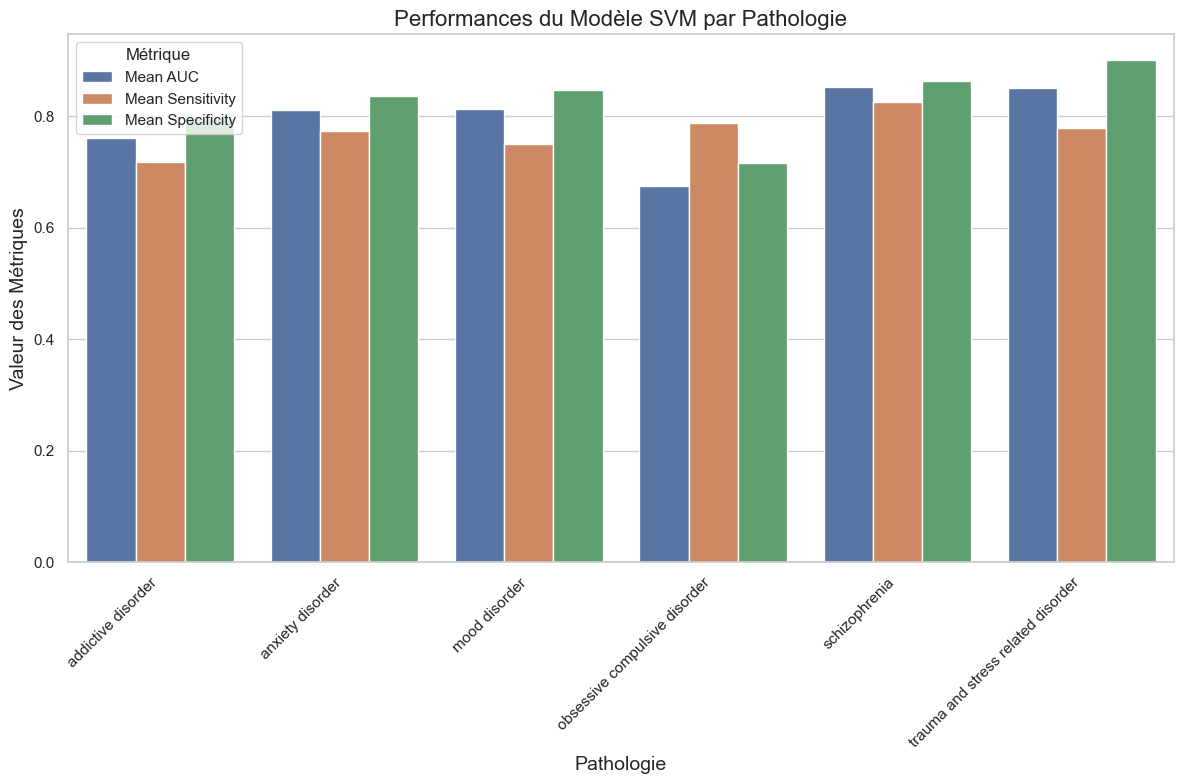

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns 


# Calculer la moyenne des métriques par pathologie
df_summary = results_svm.groupby('main.disorder').agg({
    'Mean AUC': 'mean',
    'Mean Sensitivity': 'mean',
    'Mean Specificity': 'mean'
}).reset_index()

# Transformer les données pour le tracé
df_melted = df_summary.melt(id_vars='main.disorder', 
                            value_vars=['Mean AUC', 'Mean Sensitivity', 'Mean Specificity'],
                            var_name='Métrique', 
                            value_name='Valeur')

# Afficher les données transformées
print(df_melted)

# Configurer le style de seaborn
sns.set(style="whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(12, 8))

# Créer le barplot
sns.barplot(x='main.disorder', y='Valeur', hue='Métrique', data=df_melted)

# Ajouter des titres et labels
plt.title('Performances du Modèle SVM par Pathologie', fontsize=16)
plt.xlabel('Pathologie', fontsize=14)
plt.ylabel('Valeur des Métriques', fontsize=14)

# Ajuster la rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher la légende
plt.legend(title='Métrique')

# Ajuster les marges pour éviter que les labels ne soient coupés
plt.tight_layout()

# Sauvegarder le plot sous forme d'image (optionnel)
# plt.savefig('performances_SVM_par_pathologie.png', dpi=300)

# Afficher le plot
plt.show()

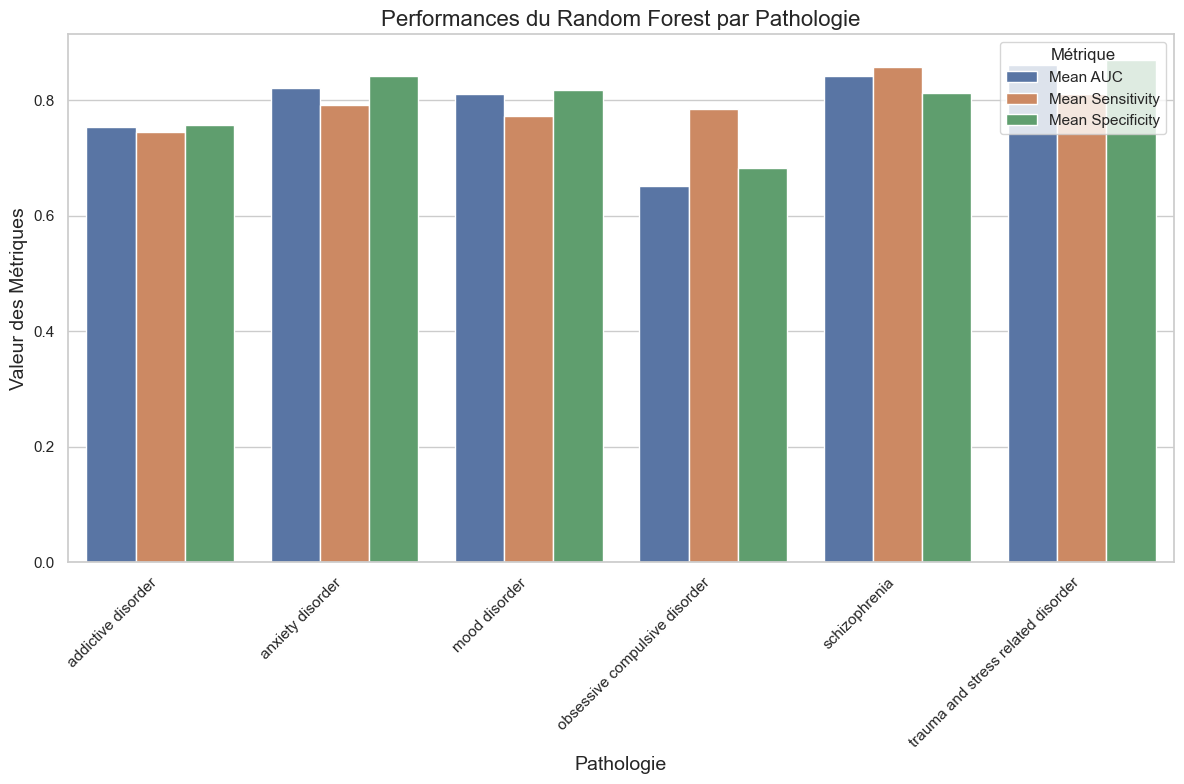

                         main.disorder          Métrique    Valeur
0                   addictive disorder          Mean AUC  0.753333
1                     anxiety disorder          Mean AUC  0.821667
2                        mood disorder          Mean AUC  0.810833
3        obsessive compulsive disorder          Mean AUC  0.652500
4                        schizophrenia          Mean AUC  0.841667
5   trauma and stress related disorder          Mean AUC  0.860833
6                   addictive disorder  Mean Sensitivity  0.745833
7                     anxiety disorder  Mean Sensitivity  0.792500
8                        mood disorder  Mean Sensitivity  0.773333
9        obsessive compulsive disorder  Mean Sensitivity  0.785000
10                       schizophrenia  Mean Sensitivity  0.858333
11  trauma and stress related disorder  Mean Sensitivity  0.810833
12                  addictive disorder  Mean Specificity  0.758333
13                    anxiety disorder  Mean Specificity  0.84

In [42]:
# Calculer la moyenne des métriques par pathologie
df_summary = results_rf.groupby('main.disorder').agg({
    'Mean AUC': 'mean',
    'Mean Sensitivity': 'mean',
    'Mean Specificity': 'mean'
}).reset_index()

# Transformer les données pour le tracé
df_melted = df_summary.melt(id_vars='main.disorder', 
                            value_vars=['Mean AUC', 'Mean Sensitivity', 'Mean Specificity'],
                            var_name='Métrique', 
                            value_name='Valeur')


# Configurer le style de seaborn
sns.set(style="whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(12, 8))

# Créer le barplot
sns.barplot(x='main.disorder', y='Valeur', hue='Métrique', data=df_melted)

# Ajouter des titres et labels
plt.title('Performances du Random Forest par Pathologie', fontsize=16)
plt.xlabel('Pathologie', fontsize=14)
plt.ylabel('Valeur des Métriques', fontsize=14)

# Ajuster la rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher la légende
plt.legend(title='Métrique')

# Ajuster les marges pour éviter que les labels ne soient coupés
plt.tight_layout()

# Afficher le plot
plt.show()
print(df_melted)

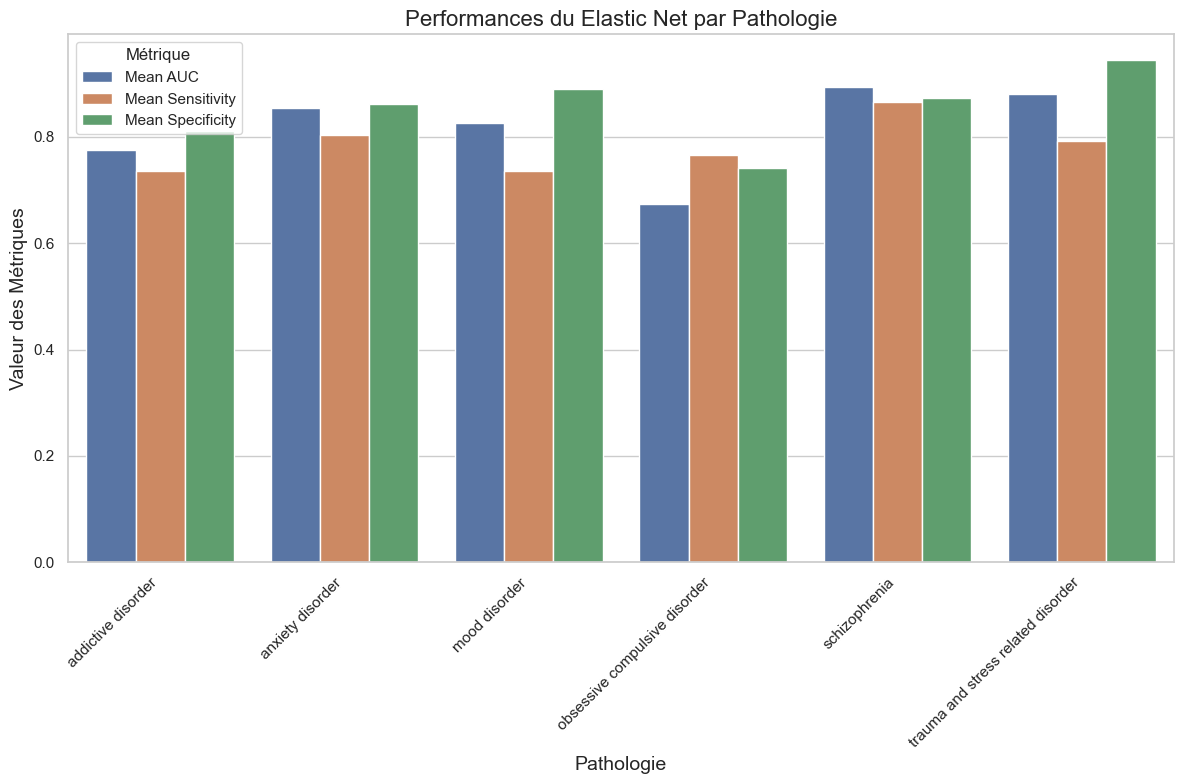

                             Pathology          Métrique    Valeur
0                   addictive disorder          Mean AUC  0.774167
1                     anxiety disorder          Mean AUC  0.853333
2                        mood disorder          Mean AUC  0.825000
3        obsessive compulsive disorder          Mean AUC  0.673333
4                        schizophrenia          Mean AUC  0.893333
5   trauma and stress related disorder          Mean AUC  0.880833
6                   addictive disorder  Mean Sensitivity  0.735000
7                     anxiety disorder  Mean Sensitivity  0.804167
8                        mood disorder  Mean Sensitivity  0.735833
9        obsessive compulsive disorder  Mean Sensitivity  0.765833
10                       schizophrenia  Mean Sensitivity  0.865833
11  trauma and stress related disorder  Mean Sensitivity  0.792500
12                  addictive disorder  Mean Specificity  0.810833
13                    anxiety disorder  Mean Specificity  0.86

In [49]:
# Calculer la moyenne des métriques par pathologie
df_summary = results_en.groupby('Pathology').agg({
    'Mean AUC': 'mean',
    'Mean Sensitivity': 'mean',
    'Mean Specificity': 'mean'
}).reset_index()

# Transformer les données pour le tracé
df_melted = df_summary.melt(id_vars='Pathology', 
                            value_vars=['Mean AUC', 'Mean Sensitivity', 'Mean Specificity'],
                            var_name='Métrique', 
                            value_name='Valeur')


# Configurer le style de seaborn
sns.set(style="whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(12, 8))

# Créer le barplot
sns.barplot(x='Pathology', y='Valeur', hue='Métrique', data=df_melted)

# Ajouter des titres et labels
plt.title('Performances du Elastic Net par Pathologie', fontsize=16)
plt.xlabel('Pathologie', fontsize=14)
plt.ylabel('Valeur des Métriques', fontsize=14)

# Ajuster la rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher la légende
plt.legend(title='Métrique')

# Ajuster les marges pour éviter que les labels ne soient coupés
plt.tight_layout()

# Afficher le plot
plt.show()

print(df_melted)

Les trois modèles semblent avoir des performances similaires mais toutes assez bonnes avec des AUC supérieures à 0.8 pour l'anxiété, les troubles de l'humeur, la schizophrénie et le PTSD, la performance est un peu moins bonne pour l'addiction (0.77) et assez faible 65 pour les troubles obsessionnels compulsifs (0.65). On peut expliquer cette baisse de performance par le déséquilibre des classes pour cette pathologie (39 contre 93 contrôles).